In [1]:
import sys
from itertools import chain, product
from typing import List, Tuple, Optional, Any, Dict
import pandas as pd

from rdkit import Chem
from rdkit.Chem import PandasTools

sys.path.append('..')
import torch.nn as nn
from torch_geometric.loader import DataLoader

from nnet.models.egnn import EquivariantGNN
from nnet.models.negnn import NaiveEuclideanGNN
from diff.preprocessing.chem import molecule_to_Data
from diff.tools import *

from rhea.chem.molecule import Molecule, to2d
from rhea.chem.moleculefilters import FragmentLikeness, RuleOfThree

AttributeError: module 'rdkit.Chem.MolStandardize' has no attribute 'Standardizer'

In [ ]:
fraglike = FragmentLikeness()
ro3 = RuleOfThree()

# Data preparation

In [ ]:
# # testing
# fig = plt.figure(figsize=(8, 8))

# for ax_pos in [221, 222, 223, 224]:
#     pos = np.random.rand(3, 5)
#     color = np.random.rand(5)
#     plot_point_cloud_3d(fig, ax_pos, color, pos)

# fig.suptitle("Random test point clouds")
# fig.tight_layout()

In [ ]:
df = PandasTools.LoadSDF('../data/QM9/raw/gdb9.sdf')
df.shape

[15:56:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[15:56:46] ERROR: Could not sanitize molecule ending on line 9097
[15:56:46] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[15:56:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[15:56:46] ERROR: Could not sanitize molecule ending on line 35785
[15:56:46] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[15:56:46] Explicit valence for atom # 4 C, 5, is greater than permitted
[15:56:46] ERROR: Could not sanitize molecule ending on line 62866
[15:56:46] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[15:56:46] Explicit valence for atom # 2 C, 5, is greater than permitted
[15:56:46] ERROR: Could not sanitize molecule ending on line 66832
[15:56:46] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[15:56:46] Explicit valence for atom # 2 C, 5, is greater than permitted
[15:56:46] ERROR: Could not sanitize molecule en

(133247, 2)

In [ ]:
props = pd.read_csv('../data/QM9/raw/gdb9.sdf.csv')
props.shape

(133885, 20)

In [ ]:
print(props.columns)
print(df.columns)

Index(['mol_id', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2',
       'zpve', 'u0', 'u298', 'h298', 'g298', 'cv', 'u0_atom', 'u298_atom',
       'h298_atom', 'g298_atom'],
      dtype='object')
Index(['ID', 'ROMol'], dtype='object')


In [ ]:
# join the two dataframes df on ID and props on mol_id
df = df.join(props.set_index('mol_id'), on='ID')
df.shape

(133247, 21)

In [ ]:
%%timeit

def filter_HA(mol: Chem.rdchem.Mol) -> bool:
    return 3 < mol.GetNumHeavyAtoms() <= 9

df["FragmentLikeness"] = df.ROMol.apply(fraglike.filter)
df["Ro3"] = df.ROMol.apply(ro3.filter)
df["HAfilter"] = df.ROMol.apply(filter_HA)

19.2 s ± 412 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
df = df[df.FragmentLikeness & df.Ro3 & df.HAfilter]
df.shape

(104941, 24)

In [ ]:
# store df using pkl
df.to_pickle('../data/QM9/raw/gdb9.pkl')

# To Data object

In [ ]:
# # load df using pkl
df = pd.read_pickle('../data/QM9/raw/gdb9.pkl')

In [ ]:
# from tqdm import tqdm

# for idx, i in enumerate(tqdm(range(len(test)))):
#     m = test.ROMol.iloc[i]
#     m = Chem.AddHs(m, addCoords=True)
#     m = Molecule(m)
#     m = molecule_to_Data(m, idx)
    
# m = df.ROMol.iloc[0]
# m = Chem.AddHs(m, addCoords=True)
# m = Molecule(m)
# d = molecule_to_Data(m, 0)

# THIS WORKED AS EXPECTED! 

In [ ]:
from tqdm import tqdm
dataset = []
# Create a Dataset
for idx, i in enumerate(tqdm(range(len(df)))):#len(df)
    m = df.ROMol.iloc[i]
    m = Chem.AddHs(m, addCoords=True)
    m = Molecule(m)
    d = molecule_to_Data(m, idx)
    dataset.append(d)

100%|██████████| 104941/104941 [02:23<00:00, 728.87it/s]


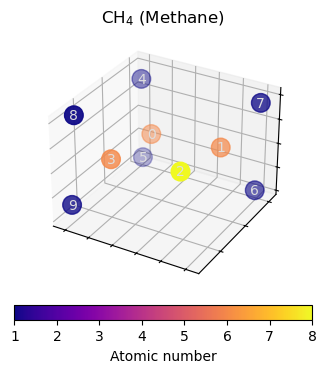

In [ ]:
fig = plt.figure()
ax = plot_model_input(dataset[5], fig, 111)
_ = ax.set_title("CH$_4$ (Methane)")

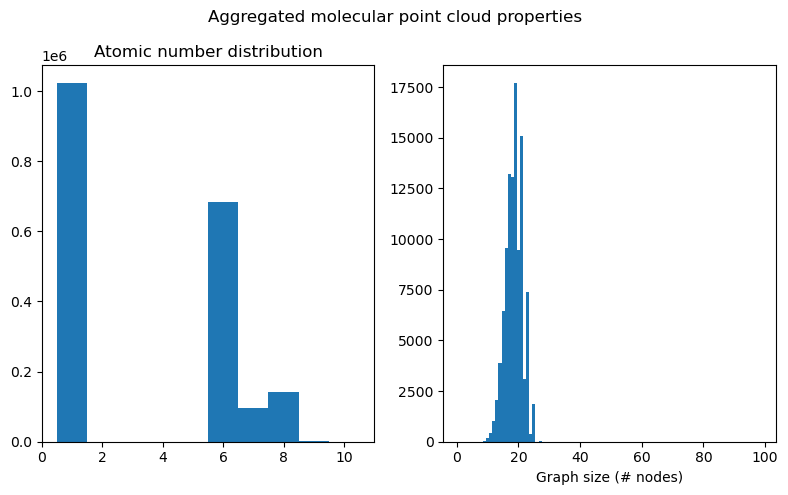

In [ ]:
fig, (ax_atoms, ax_graph_size) = plt.subplots(1, 2, figsize=(8, 5))

# historgam of z values (atomic numbers) for all the molecules
ax_atoms.hist(list(chain(*[d.z for d in dataset])), bins=range(1, 12), align='left')
ax_atoms.set_label("Atomic number")
ax_atoms.set_title("Atomic number distribution")
num_nodes = [d.num_nodes for d in dataset]
ax_graph_size.hist(num_nodes, bins=range(1, 100), align='left')
ax_graph_size.set_xlabel("Graph size (# nodes)")
fig.suptitle("Aggregated molecular point cloud properties")
fig.tight_layout()

In [ ]:
def shuffle_splits(dataset:List[Data], 
                   train_ratio:float,
                   val_ratio:float,
                   test_ratio:float,
                   seed:int=42) -> Tuple[List[Data], List[Data], List[Data]]:
    """
    Shuffle and split a dataset into training, validation and test sets.
    
    Args:
    - dataset: List of Data objects
    - train_ratio: float, ratio of training set
    - val_ratio: float, ratio of validation set
    - test_ratio: float, ratio of test set
    - seed: int, random seed
    
    Returns:
    - train_loader: DataLoader for training set
    - val_loader: DataLoader for validation set
    - test_loader: DataLoader for test set
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"    
    
    np.random.seed(seed)
    N = len(dataset)
    indices = np.random.permutation(N)
    
    train_end = int(train_ratio * N)
    val_end = int((train_ratio + val_ratio) * N)
    
    train_loader = DataLoader([dataset[i] for i in indices[:train_end]], batch_size=32, shuffle=True)
    val_loader = DataLoader([dataset[i] for i in indices[train_end:val_end]], batch_size=32)
    test_loader = DataLoader([dataset[i] for i in indices[val_end:]], batch_size=32)
    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = shuffle_splits(dataset, 0.8, 0.1, 0.1)

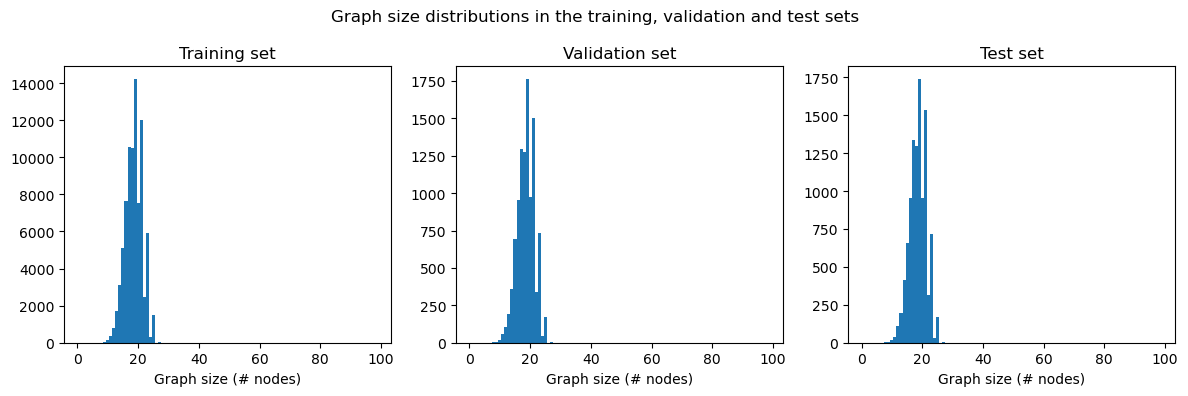

In [ ]:
# see plot https://projects.volkamerlab.org/teachopencadd/talktorials/T036_e3_equivariant_gnn.html
# plot distribution of graph sizes in the training, validation and test sets
fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(12, 4))

train_sizes = [d.num_nodes for d in train_loader.dataset]
val_sizes = [d.num_nodes for d in val_loader.dataset]
test_sizes = [d.num_nodes for d in test_loader.dataset]

ax_train.hist(train_sizes, bins=range(1, 100), align='left')
ax_train.set_xlabel("Graph size (# nodes)")
ax_train.set_title("Training set")

ax_val.hist(val_sizes, bins=range(1, 100), align='left')
ax_val.set_xlabel("Graph size (# nodes)")
ax_val.set_title("Validation set")

ax_test.hist(test_sizes, bins=range(1, 100), align='left')
ax_test.set_xlabel("Graph size (# nodes)")
ax_test.set_title("Test set")

fig.suptitle("Graph size distributions in the training, validation and test sets")
fig.tight_layout()

In [ ]:
import math 

# use rotations along z-axis as demo e(3) transformation
def rotation_matrix_z(theta: float) -> Tensor:
    """Generates a rotation matrix and returns
    a corresponing tensor. The rotation is about the $z$-axis.
    (https://en.wikipedia.org/wiki/Rotation_matrix)

    Parameters
    ----------
    theta : float
        the angle of rotation.

    Returns
    -------
    Tensor
        the rotation matrix as float tensor.
    """
    return torch.tensor(
        [
            [math.cos(theta), -math.sin(theta), 0],
            [math.sin(theta), math.cos(theta), 0],
            [0, 0, 1],
        ]
    )

In [ ]:
sample_data = dataset[0].clone()

rotated_data = sample_data.clone()

rotated_data.pos = rotated_data.pos @ rotation_matrix_z(45)

In [ ]:
model = NaiveEuclideanGNN(
    hidden_channels=32,
    num_layers=2,
    num_spatial_dims=3,
    final_embedding_size=1,
)


C:\Users\cabe\AppData\Local\Temp\ipykernel_22436\1040294942.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


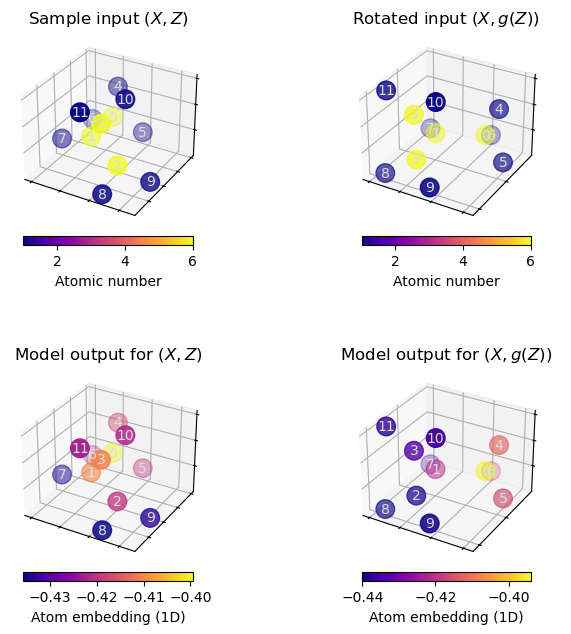

In [ ]:
fig = plt.figure(figsize=(8, 8))

ax1 = plot_model_input(sample_data, fig, 221)
ax1.set_title("Sample input $(X, Z)$")

ax2 = plot_model_input(rotated_data, fig, 222)
ax2.set_title("Rotated input $(X, g(Z))$")

ax3 = plot_model_embedding(sample_data, model.encode, fig, 223)
ax3.set_title("Model output for $(X, Z)$")

ax4 = plot_model_embedding(rotated_data, model.encode, fig, 224)
ax4.set_title("Model output for $(X, g(Z))$")
fig.tight_layout()

When executing the above cells a few times, we can observe that rotating the molecule may significantly alter the atom embeddings obtained from the plain GNN model.

C:\Users\cabe\AppData\Local\Temp\ipykernel_22436\2072519676.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


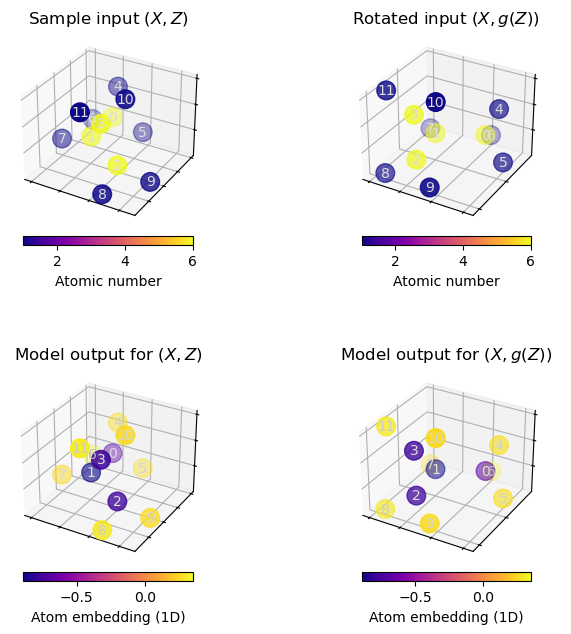

In [ ]:
model = EquivariantGNN(hidden_channels=32, final_embedding_size=1, num_mp_layers=2)

sample_data = dataset[0].clone()

rotated_data = sample_data.clone()

rotated_data.pos = rotated_data.pos @ rotation_matrix_z(45)

fig = plt.figure(figsize=(8, 8))

ax1 = plot_model_input(sample_data, fig, 221)
ax1.set_title("Sample input $(X, Z)$")

ax2 = plot_model_input(rotated_data, fig, 222)
ax2.set_title("Rotated input $(X, g(Z))$")

ax3 = plot_model_embedding(sample_data, model.encode, fig, 223)
ax3.set_title("Model output for $(X, Z)$")

ax4 = plot_model_embedding(rotated_data, model.encode, fig, 224)
ax4.set_title("Model output for $(X, g(Z))$")
fig.tight_layout()

You can execute the above cells as often as you like, with whatever input you choose, the atom embeddings will always be unaffected by the rotation applied to the model input.

In [ ]:
def total_absolute_error(pred: Tensor, target: Tensor, batch_dim: int = 0) -> Tensor:
    """Total absolute error, i.e. sums over batch dimension.

    Parameters
    ----------
    pred : Tensor
        batch of model predictions
    target : Tensor
        batch of ground truth / target values
    batch_dim : int, optional
        dimension that indexes batch elements, by default 0

    Returns
    -------
    Tensor
        total absolute error
    """
    return (pred - target).abs().sum(batch_dim)

def total_absolute_error(pred: Tensor, target: Tensor) -> Tensor:
    return torch.mean(torch.abs(pred - target))

def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: Callable[[Tensor, Tensor], Tensor],
    pbar: Optional[Any] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    device: str = "cuda"
) -> Tuple[float, float]:
    """Run a single epoch.

    Parameters
    ----------
    model : nn.Module
        the NN used for regression
    loader : DataLoader
        an iterable over data batches
    criterion : Callable[[Tensor, Tensor], Tensor]
        a criterion (loss) that is optimized
    pbar : Optional[Any], optional
        a tqdm progress bar, by default None
    optim : Optional[torch.optim.Optimizer], optional
        an optimizer that is optimizing the criterion, by default None
    """

    # def step(
    #     data_batch: Any,
    # ) -> Tuple[float, float]:
    #     """Perform a single train/val step on a data batch.

    #     Parameters
    #     ----------
    #     data_batch : Any

    #     Returns
    #     -------
    #     Tuple[float, float]
    #         Loss (mean squared error) and validation criterion (absolute error).
    #     """
    #     data_batch = data_batch.to(device)
    #     pred = model(data_batch)
    #     target = data_batch.y.to(device)
    #     loss = criterion(pred, target)
    #     if optim is not None:
    #         optim.zero_grad()
    #         loss.backward()
    #         optim.step()
    #     return loss.detach().item(), total_absolute_error(pred.detach(), target.detach()).item()
    def step(data_batch: Any) -> Tuple[float, float]:
        """Perform a single train/val step on a data batch.
        
        Parameters
        ----------
        data_batch: Tuple[Tensor, Tensor]
            A batch of data (features and targets).
        
        Returns
        -------
        Tuple[float, float]
            Loss (mean squared error) and validation criterion (absolute error).
        """
        # Unpack the batch into features and targets
        x_batch, y_batch = data_batch
        
        # Move features and targets to the device (e.g., GPU)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        pred = model(x_batch)
        
        # Compute loss (assuming a criterion like MSELoss is defined)
        loss = criterion(pred, y_batch)
        
        # Compute MAE (or any other evaluation metric)
        mae = torch.mean(torch.abs(pred - y_batch))
        
        return loss.item(), mae.item()
    if optim is not None:
        model.train()
        # This enables pytorch autodiff so we can compute gradients
        model.requires_grad_(True)
    else:
        model.eval()
        # Disable autodiff: when evaluating we do not need to track gradients
        model.requires_grad_(False)

    total_loss = 0
    total_mae = 0
    for data in loader:
        loss, mae = step(data)
        total_loss += loss * data.num_graphs
        total_mae += mae
        if pbar is not None:
            pbar.update(1)

    return total_loss / len(loader.dataset), total_mae / len(loader.dataset)


def train_model(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    num_epochs: int = 30,
    lr: float = 3e-4,
    weight_decay: float = 1e-8,
    device: str = "cuda",
    best_model_path: str = "best_model.pt") -> Dict[str, Any]:
    """Train a model."""
    
    model = model.to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    
    best_val_mae = float("inf")
    
    result = {
        "model": model,
        "train_losses": np.full(num_epochs, np.nan),
        "train_maes": np.full(num_epochs, np.nan),
        "val_losses": np.full(num_epochs, np.nan),
        "val_maes": np.full(num_epochs, np.nan),
        "path": best_model_path,
    }
    
    def update_statistics(i_epoch:int, **kwargs:float) -> None:
        for key, value in kwargs.items():
            result[key][i_epoch] = value
    
    def desc(i_epoch: int) -> str:
        return "|".join(
            [f"Epoch {i_epoch + 1:3d} / {num_epochs}"] +
            [f"{key}: {value[i_epoch]:8.2f}" for key, value in result.items() if isinstance(value, np.ndarray)]
        )

    for i_epoch in range(num_epochs):
        pbar = tqdm(total=len(train_loader)+len(val_loader))
        try:
            pbar.set_description(desc(i_epoch))
            
            train_loss, train_mae = run_epoch(model, train_loader, criterion, pbar, optim, device)
            val_loss, val_mae = run_epoch(model, val_loader, criterion, pbar, None, device)
            
            update_statistics(i_epoch, train_losses=train_loss, train_maes=train_mae, val_losses=val_loss, val_maes=val_mae)
            
            pbar.set_description(desc(i_epoch))
            
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                torch.save(model.state_dict(), best_model_path)
        finally:
            pbar.close()
    
    return result

@torch.no_grad()
def test_model(model: nn.Module, data_loader: DataLoader, device: str = "cuda") -> float:
    """Test a model on a data loader.

    Parameters
    ----------
    model : nn.Module
        the model to be tested
    data_loader : DataLoader
        the data loader to be used
    device : str, optional
        the device to use, by default "cuda"

    Returns
    -------
    float
        the mean absolute error
    """
    model = model.to(device)
    model.eval()
    model.requires_grad_(False)
    
    total_mae = 0
    for data in data_loader:
        data = data.to(device)
        pred = model(data)
        target = data.y.to(device)
        total_mae += total_absolute_error(pred, target).item()
    
    return total_mae / len(data_loader.dataset)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = EquivariantGNN(hidden_channels=64, num_mp_layers=2).to(device)


egnn_train_result = train_model(
    train_loader,
    val_loader,
    model,
    num_epochs=5,
    lr=1e-3,
    weight_decay=1e-8,
    device=device,
    best_model_path="best_egnn_model.pt",
)

Epoch   1 / 5|train_losses:      nan|train_maes:      nan|val_losses:      nan|val_maes:      nan:   0%|          | 0/2952 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [ ]:
egnn_train_result

{'model': EquivariantGNN(
   (act): ReLU()
   (f_initial_embed): Embedding(100, 64)
   (message_passing_layers): ModuleList(
     (0-1): 2 x EquivariantMPLayer(
       (act): ReLU()
       (residual_proj): Linear(in_features=64, out_features=64, bias=False)
       (message_mlp): Sequential(
         (0): Linear(in_features=129, out_features=64, bias=True)
         (1): ReLU()
       )
       (node_update_mlp): Sequential(
         (0): Linear(in_features=128, out_features=64, bias=True)
         (1): ReLU()
       )
     )
   )
   (aggregation): SumAggregation()
   (f_predict): Sequential(
     (0): Linear(in_features=64, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 'train_losses': array([1.38192589e+00, 5.47895010e-03, 1.25935926e-02, 4.55285528e-05,
        1.49804577e-04]),
 'train_maes': array([0.00401275, 0.00141766, 0.00099409, 0.00015347, 0.00024314]),
 'val_losses': array([1.23915638e-03, 1.25180991e-02, 5.20

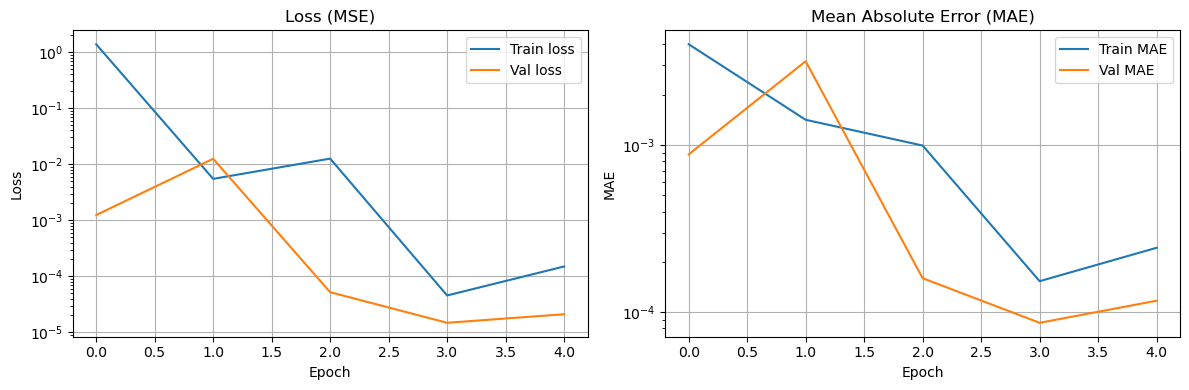

In [ ]:
# plot training and validation losses
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(egnn_train_result["train_losses"], label="Train loss")
ax[0].plot(egnn_train_result["val_losses"], label="Val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss (MSE)")

ax[1].plot(egnn_train_result["train_maes"], label="Train MAE")
ax[1].plot(egnn_train_result["val_maes"], label="Val MAE")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("MAE")
ax[1].set_title("Mean Absolute Error (MAE)")

for a in ax:
    a.legend()
    a.grid()
    a.set_yscale("log")
    
fig.tight_layout()

In [ ]:
# create a example input of a graph representation X = [x, h], where
# x is the coordinates of the atoms and h are one-hot encoded atomic types
def mols_to_X(df: pd.DataFrame) -> List[Tensor]:
    X = []
    for idx in tqdm(range(len(df))):
        m = df.ROMol.iloc[idx]
        m = Chem.AddHs(m, addCoords=True)
        m = Molecule(m)

        x = torch.tensor(m.get_coordinates(), dtype=torch.float32)
        atom_types = torch.tensor([atom.GetAtomicNum() for atom in m.molecule.GetAtoms()])
        h = torch.nn.functional.one_hot(atom_types, num_classes=10).float()

        X.append(torch.cat([x, h], dim=-1))
    return X

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset, random_split

def prepare_loaders(X: List[torch.Tensor], y: List[torch.Tensor], batch_size: int = 32, val_split: float = 0.2):
    """
    Prepare train and validation DataLoaders with padding.
    
    Args:
        X (List[torch.Tensor]): List of input feature tensors.
        y (List[torch.Tensor]): List of target tensors.
        batch_size (int): Batch size for DataLoader.
        val_split (float): Proportion of data to use for validation.
    
    Returns:
        Tuple[DataLoader, DataLoader]: Train and validation DataLoaders.
    """
    # Pad the input tensors so they have the same size along the first dimension
    X_padded = pad_sequence(X, batch_first=True)
    
    # Convert the list of target tensors to a single tensor
    y_tensor = torch.stack(y)
    
    # Create a TensorDataset
    dataset = TensorDataset(X_padded, y_tensor)
    
    # Determine the size of the validation set
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    
    # Split the dataset into training and validation sets
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Create DataLoaders for train and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


In [ ]:
class EGNNLayer(nn.Module):
    def __init__(self, in_nf: int, out_nf: int, hidden_nf: int, edged_ind_d: int = 0, act_fn: nn.Module = nn.SiLU(), 
                 residual: bool = True, attention: bool = True, normalize: bool = True, tanh: bool = False, coords_agg: str = "mean"):
        super(EGNNLayer, self).__init__()
        input_edge = in_nf * 2
        self.residual = residual
        self.attention = attention
        self.normalize = normalize
        self.coords_agg = coords_agg
        self.tanh = tanh
        self.eps = 1e-8
        edge_coords_nf = 1

        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edge_coords_nf + edged_ind_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn,
        )

        self.node_mlp = nn.Sequential(
            nn.Linear(in_nf + hidden_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, out_nf),
        )

        layer = nn.Linear(hidden_nf, 1, bias=False)
        nn.init.xavier_uniform_(layer.weight, gain = 0.001)
        self.register_buffer("layer", layer.weight)

        coord_mlp = []
        coord_mlp.append(nn.Linear(hidden_nf, hidden_nf))          # 1
        coord_mlp.append(act_fn)
        coord_mlp.append(layer)                         # 2     

        if tanh:
            coord_mlp.append(nn.Tanh())
        self.coord_mlp = nn.Sequential(*coord_mlp)

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid()
            )

    def edge_model(self, source: Tensor, target: Tensor, edge_attr: Tensor, radial: Tensor) -> Tensor:
        if edge_attr is None:
            out = torch.cat([source, target, radial], dim=-1)
        else:
            out = torch.cat([source, target, edge_attr, radial], dim=-1)
        out = self.edge_mlp(out)

        if self.attention:
            att = self.att_mlp(out)
            out = out * att
        return out
    
    def node_model()

class EGNN(nn.Module):
    def __init__(self, in_node_nf: int, hidden_nf: int, out_node_nf:int = 0, device: str = "cuda", 
                 n_layers: int = 4, act_fn: nn.Module = nn.SiLU(), residual: bool = True, attention: bool = True,
                 normalize: bool = True, tanh: bool = False):
        """
        :param in_node_nf: Number of features for 'h' at the input layer
        :param out_node_nf: Number of features for 'h' at the output
        :param in_edge_nf: Number of features for the edge features
        :param device: Device (e.g. 'cpu', 'cuda:0',...)
        :param act_fn: Non-linearity
        :param n_layers: Number of layer for the EGNN
        :param residual: Use residual connections, we recommend not changing this one
        :param attention: Whether using attention or not
        :param normalize: Normalizes the coordinates messages such that:
                    instead of: x^{l+1}_i = x^{l}_i + Σ(x_i - x_j)phi_x(m_ij)
                    we get:     x^{l+1}_i = x^{l}_i + Σ(x_i - x_j)phi_x(m_ij)/||x_i - x_j||
                    We noticed it may help in the stability or generalization in some future works.
                    We didn't use it in our paper.
        :param tanh: Sets a tanh activation function at the output of phi_x(m_ij). I.e. it bounds the output of
                        phi_x(m_ij) which definitely improves in stability but it may decrease in accuracy.
                        We didn't use it in our paper.
        """
        super(EGNN, self).__init__()
        self.device = device
        self.n_layers = n_layers
        self.residual = residual
        self.attention = attention
        self.normalize = normalize
        self.tanh = tanh
        self.act_fn = act_fn
        self.in_node_nf = in_node_nf
        self.hidden_nf = hidden_nf
        self.out_node_nf = out_node_nf
        self.embedding_in = nn.Linear(in_node_nf, hidden_nf)
        self.embedding_out = nn.Linear(hidden_nf, out_node_nf)

        for i in range(n_layers):
            self.add_module(f"layer_{i}", EGNNLayer(hidden_nf, hidden_nf, hidden_nf, device, act_fn, residual, attention, normalize, tanh))
        self.to(device)

    def forward(self, h: Tensor, x: Tensor, edge_index: Tensor, edge_attr: Tensor):
        """
        :param h: Node features (N, in_node_nf)
        :param x: Node coordinates (N, 3)
        :param edge_index: Edge index (2, E)
        :param edge_attr: Edge features (E, in_edge_nf)
        :return: Node features (N, out_node_nf)
        """
        h = self.embedding_in(h)
        for i in range(self.n_layers):
            h = self._modules[f"gcl_{i}d"](h, x, edge_index, edge_attr)
        return self.embedding_out(h)

In [ ]:

X = mols_to_X(df)

# create random target values
y = [torch.rand(1) for _ in range(len(df))]
train_loader, val_loader = prepare_loaders(X, y, batch_size=32, val_split=0.2)


# create a simple model
egnn = EquivariantGNN(hidden_channels=64, num_mp_layers=2).to(device)

# train the model
egnn_train_result = train_model(
    train_loader,
    val_loader,
    egnn,
    num_epochs=5,
    lr=1e-3,
    weight_decay=1e-8,
    device=device,
    best_model_path="best_egnn_model.pt",
)

100%|██████████| 104941/104941 [01:00<00:00, 1746.28it/s]
Epoch   1 / 5|train_losses:      nan|train_maes:      nan|val_losses:      nan|val_maes:      nan:   0%|          | 0/3280 [00:00<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'z'

In [ ]:
#plot training and validation losses
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(egnn_train_result["train_losses"], label="Train loss")
ax[0].plot(egnn_train_result["val_losses"], label="Val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss (MSE)")

ax[1].plot(egnn_train_result["train_maes"], label="Train MAE")
ax[1].plot(egnn_train_result["val_maes"], label="Val MAE")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("MAE")
ax[1].set_title("Mean Absolute Error (MAE)")

for a in ax:
    a.legend()
    a.grid()
    a.set_yscale("log")

fig.tight_layout()

,ID,ROMol,A,B,C,mu,alpha,homo,lumo,gap,...,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom,FragmentLikeness,Ro3,HAfilter
42,gdb_43,<rdkit.Chem.rdchem.Mol object at 0x0000017AAF1...,15.61472,6.31363,5.54514,0.1136,41.96,-0.2727,0.1012,0.3738,...,-157.111146,-157.143262,16.490,-1083.998580,-1091.748943,-1098.270017,-1010.652190,True,True,True
43,gdb_44,<rdkit.Chem.rdchem.Mol object at 0x0000017AAF1...,18.21931,6.63877,5.92459,1.8120,35.01,-0.2633,0.1052,0.3685,...,-193.034242,-193.065979,14.764,-899.264323,-905.380025,-910.715107,-838.938117,True,True,True
44,gdb_45,<rdkit.Chem.rdchem.Mol object at 0x0000017AAF1...,16.58914,7.18798,6.11415,1.1353,39.02,-0.2304,0.0968,0.3271,...,-173.142399,-173.174073,15.298,-954.876680,-961.867131,-967.795208,-887.759573,True,True,True
45,gdb_46,<rdkit.Chem.rdchem.Mol object at 0x0000017AAF1...,16.79477,6.71015,5.86781,1.3894,34.64,-0.2390,0.0775,0.3166,...,-193.029411,-193.061689,15.679,-896.368369,-902.349157,-907.683611,-836.246104,True,True,True
46,gdb_47,<rdkit.Chem.rdchem.Mol object at 0x0000017AAF1...,10.66107,10.66107,6.30452,0.0000,41.83,-0.2982,0.0956,0.3938,...,-157.110378,-157.141657,14.696,-1083.213566,-1091.267016,-1097.788090,-1009.645038,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133861,gdb_133862,<rdkit.Chem.rdchem.Mol object at 0x0000017B400...,2.70455,1.64610,1.41364,2.7921,80.93,-0.2206,0.0723,0.2929,...,-402.997441,-403.037739,31.855,-1836.879485,-1849.812446,-1861.073722,-1700.482874,True,True,True
133862,gdb_133863,<rdkit.Chem.rdchem.Mol object at 0x0000017B400...,2.74553,2.00151,1.36002,0.4506,91.34,-0.2008,-0.0152,0.1856,...,-349.782124,-349.822503,31.336,-1986.985286,-2000.868295,-2012.723195,-1844.579021,True,True,True
133863,gdb_133864,<rdkit.Chem.rdchem.Mol object at 0x0000017B400...,2.83041,1.99840,1.41781,1.9977,91.95,-0.1386,-0.0638,0.0747,...,-385.740236,-385.779365,29.845,-1824.050064,-1836.472232,-1847.141140,-1694.291243,True,True,True
133864,gdb_133865,<rdkit.Chem.rdchem.Mol object at 0x0000017B400...,2.89460,2.08696,1.42818,2.1480,88.57,-0.1325,-0.0539,0.0786,...,-401.784247,-401.823773,29.474,-1703.152297,-1714.596179,-1724.672091,-1579.930865,True,True,True


# Equivariant diffusion models (EDM) Hoogeboom et al. 2022

EDM gradually inject noise to the molecule z = (x, h) via forward process:

$q(z_{1:N}|z_0) = \prod_{n=1}^{N}q(z_n|z_{n-1}), q(z_n|z_{n-1}) =  \mathcal{\text{N}_X}(x_n|\sqrt{\alpha_{n}X_{n-1}}, \beta_n)\mathcal{\text{N}}(h_n|\sqrt{\alpha_{n}h_{n-1}}, \beta_n)$

Where $\alpha_n$ and $\beta_n$ represent the noise schedule, $\mathcal{\text{N}_X}$ rpresent the Gaussian distribution in the zero CoM subspace X:

- Suppose $\mu \in X$. Let $\mathcal{\text{N}_X}(x|\mu, \sigma^2):=(2\pi\sigma^2)^{-(M-1)^n/2}\exp(-\frac{1}{2\sigma^2}\lVert x-\mu \rVert^2)$

- Let $\hat{\alpha_n} = \alpha_1\alpha_2...\alpha_n = $, $\hat{\beta_n} = 1 - \hat{\alpha_n}$ and $\tilde{\beta_n} = \beta_n\hat{\beta_{n-1}}\sqrt{\beta_n}$

To generate samples, the forward process is reversed using a Markov chain:

$p(z_{0:N}) = p(Z_N)\prod_{n=1}^{N}p(z_{n-1}|z_n)$,
$p(z_{n-1}|z_n) = \mathcal{\text{N}_X}(x_{n-1}|\mu_n^x(Z_n), \tilde{\beta_n})\mathcal{\text{N}}(h_{n-1}|\mu_n^h(Z_n), \tilde{\beta_n})$

In [ ]:
# define noise scheduler
import numpy as np

def noise_scheduler(num_steps, beta_start=0.0001, beta_end=0.02) -> Tuple[Tensor, Tensor, Tensor, Tensor, Tensor]:
    """
    Generate the noise schedule arrays for the diffusion process.

    Parameters:
    - num_steps: Number of diffusion steps (N).
    - beta_start: Initial value for beta.
    - beta_end: Final value for beta.

    Returns:
    - alphas: Array of alpha_n values for each step.
    - betas: Array of beta_n values for each step.
    - alpha_hats: Array of cumulative product of alphas up to each step (alpha_hat_n).
    - beta_hats: Array of 1 - alpha_hat_n values.
    - tilde_betas: Array of tilde_beta_n values for each step.
    """
    # Linearly interpolate beta values over the diffusion steps
    betas = np.linspace(beta_start, beta_end, num_steps)
    alphas = 1.0 - betas

    # Cumulative products for alpha
    alpha_hats = np.cumprod(alphas)
    beta_hats = 1.0 - alpha_hats

    # Calculate tilde_beta_n values
    tilde_betas = betas * np.append(1.0, np.cumprod(alphas[:-1])) * np.sqrt(betas)

    return torch.tensor(alphas, dtype=torch.float32), torch.tensor(betas, dtype=torch.float32), \
           torch.tensor(alpha_hats, dtype=torch.float32), torch.tensor(beta_hats, dtype=torch.float32), \
           torch.tensor(tilde_betas, dtype=torch.float32)

# Example usage:
num_steps = 1000  # Total number of diffusion steps
alphas, betas, alpha_hats, beta_hats, tilde_betas = noise_scheduler(num_steps)

# Print first few values as an example
print("alphas[:5]:", alphas[:5])
print("betas[:5]:", betas[:5])
print("alpha_hats[:5]:", alpha_hats[:5])
print("beta_hats[:5]:", beta_hats[:5])
print("tilde_betas[:5]:", tilde_betas[:5])

alphas[:5]: tensor([0.9999, 0.9999, 0.9999, 0.9998, 0.9998])
betas[:5]: tensor([1.0000e-04, 1.1992e-04, 1.3984e-04, 1.5976e-04, 1.7968e-04])
alpha_hats[:5]: tensor([0.9999, 0.9998, 0.9996, 0.9995, 0.9993])
beta_hats[:5]: tensor([1.0000e-04, 2.1991e-04, 3.5972e-04, 5.1942e-04, 6.9901e-04])
tilde_betas[:5]: tensor([1.0000e-06, 1.3131e-06, 1.6533e-06, 2.0186e-06, 2.4073e-06])


In [ ]:
X[0].shape

torch.Size([12, 13])

In [ ]:
def forward_diffusion(X: Tensor, num_steps: int) -> Tensor:
    """
    Forward diffusion process.

    Parameters:
    - X: Input tensor of shape (N, D) where N is the number of nodes and D is the number of features.
    - num_steps: Number of diffusion steps (N).

    Returns:
    - X_diffused: Diffused tensor of shape (N, D) after num_steps diffusion steps.
    """
    x, h = X[:, :3], X[:, 3:]
    # print(x.shape, h.shape) OK
    # Get noise schedule
    alphas, betas, alpha_hats, beta_hats, tilde_betas = noise_scheduler(num_steps)

    # Initialize the diffused tensors X and h
    X_diffused = [x.clone()]
    h_diffused = [h.clone()]

    # Perform the forward diffusion process
    for n in range(1, num_steps):
        noise_x = torch.randn_like(x) * np.sqrt(betas[n])
        noise_h = torch.randn_like(h) * np.sqrt(betas[n])
        # Diffusion step
        x_n = torch.sqrt(alphas[n]) * x + noise_x
        h_n = torch.sqrt(alphas[n]) * h + noise_h
        # Store the diffused tensors
        X_diffused.append(x_n)
        h_diffused.append(h_n)
        # Update the current tensors
        x, h = x_n, h_n
    
    # Concatenate the diffused tensors along the feature dimension
    X_diffused = torch.stack(X_diffused, dim=0)
    h_diffused = torch.stack(h_diffused, dim=0)
    return torch.cat([X_diffused, h_diffused], dim=-1)


torch.manual_seed(42)

forward_diffusion(X[0], 1000)

tensor([[[-3.6000e-02,  1.5209e+00,  1.5700e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.9400e-02,  1.0000e-02,  4.8100e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.3089e+00, -7.1250e-01, -2.4920e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 2.2689e+00, -4.3406e-01, -7.0840e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.2583e+00, -1.2346e-01,  1.9428e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 4.8936e-01, -1.4746e+00,  1.8934e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-1.4897e-02,  1.5371e+00,  2.5563e-02,  ...,  1.7583e-03,
          -1.0711e-03,  2.0200e-02],
         [-3.6583e-03,  1.7429e-02,  3.4578e-02,  ..., -2.1609e-03,
          -1.1549e-02,  1.3995e-02],
         [ 1.3083e+00, -7.3003e-01, -2.5742e-01,  ..., -8.2219e-03,
           3.0816e-02,  3.9400e-03],
         ...,
         [ 2.2595e+00, -4

In [ ]:
from torch import nn
import torch
import math

class GCL(nn.Module):
    def __init__(self, input_nf, output_nf, hidden_nf, normalization_factor, aggregation_method,
                 edges_in_d=0, nodes_att_dim=0, act_fn=nn.SiLU(), attention=False):
        super(GCL, self).__init__()
        input_edge = input_nf * 2
        self.normalization_factor = normalization_factor
        self.aggregation_method = aggregation_method
        self.attention = attention

        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

    def edge_model(self, source, target, edge_attr, edge_mask):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target], dim=1)
        else:
            out = torch.cat([source, target, edge_attr], dim=1)
        mij = self.edge_mlp(out)

        if self.attention:
            att_val = self.att_mlp(mij)
            out = mij * att_val
        else:
            out = mij

        if edge_mask is not None:
            out = out * edge_mask
        return out, mij

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0),
                                   normalization_factor=self.normalization_factor,
                                   aggregation_method=self.aggregation_method)
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = x + self.node_mlp(agg)
        return out, agg

    def forward(self, h, edge_index, edge_attr=None, node_attr=None, node_mask=None, edge_mask=None):
        row, col = edge_index
        edge_feat, mij = self.edge_model(h[row], h[col], edge_attr, edge_mask)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        if node_mask is not None:
            h = h * node_mask
        return h, mij


class EquivariantUpdate(nn.Module):
    def __init__(self, hidden_nf, normalization_factor, aggregation_method,
                 edges_in_d=1, act_fn=nn.SiLU(), tanh=False, coords_range=10.0):
        super(EquivariantUpdate, self).__init__()
        self.tanh = tanh
        self.coords_range = coords_range
        input_edge = hidden_nf * 2 + edges_in_d
        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)
        self.coord_mlp = nn.Sequential(
            nn.Linear(input_edge, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn,
            layer)
        self.normalization_factor = normalization_factor
        self.aggregation_method = aggregation_method

    def coord_model(self, h, coord, edge_index, coord_diff, edge_attr, edge_mask):
        row, col = edge_index
        input_tensor = torch.cat([h[row], h[col], edge_attr], dim=1)
        if self.tanh:
            trans = coord_diff * torch.tanh(self.coord_mlp(input_tensor)) * self.coords_range
        else:
            trans = coord_diff * self.coord_mlp(input_tensor)
        if edge_mask is not None:
            trans = trans * edge_mask
        agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0),
                                   normalization_factor=self.normalization_factor,
                                   aggregation_method=self.aggregation_method)
        coord = coord + agg
        return coord

    def forward(self, h, coord, edge_index, coord_diff, edge_attr=None, node_mask=None, edge_mask=None):
        coord = self.coord_model(h, coord, edge_index, coord_diff, edge_attr, edge_mask)
        if node_mask is not None:
            coord = coord * node_mask
        return coord


class EquivariantBlock(nn.Module):
    def __init__(self, hidden_nf, edge_feat_nf=2, device='cpu', act_fn=nn.SiLU(), n_layers=2, attention=True,
                 norm_diff=True, tanh=False, coords_range=15, norm_constant=1, sin_embedding=None,
                 normalization_factor=100, aggregation_method='sum'):
        super(EquivariantBlock, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        self.coords_range_layer = float(coords_range)
        self.norm_diff = norm_diff
        self.norm_constant = norm_constant
        self.sin_embedding = sin_embedding
        self.normalization_factor = normalization_factor
        self.aggregation_method = aggregation_method

        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, GCL(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=edge_feat_nf,
                                              act_fn=act_fn, attention=attention,
                                              normalization_factor=self.normalization_factor,
                                              aggregation_method=self.aggregation_method))
        self.add_module("gcl_equiv", EquivariantUpdate(hidden_nf, edges_in_d=edge_feat_nf, act_fn=nn.SiLU(), tanh=tanh,
                                                       coords_range=self.coords_range_layer,
                                                       normalization_factor=self.normalization_factor,
                                                       aggregation_method=self.aggregation_method))
        self.to(self.device)

    def forward(self, h, x, edge_index, node_mask=None, edge_mask=None, edge_attr=None):
        # Edit Emiel: Remove velocity as input
        distances, coord_diff = coord2diff(x, edge_index, self.norm_constant)
        if self.sin_embedding is not None:
            distances = self.sin_embedding(distances)
        edge_attr = torch.cat([distances, edge_attr], dim=1)
        for i in range(0, self.n_layers):
            h, _ = self._modules["gcl_%d" % i](h, edge_index, edge_attr=edge_attr, node_mask=node_mask, edge_mask=edge_mask)
        x = self._modules["gcl_equiv"](h, x, edge_index, coord_diff, edge_attr, node_mask, edge_mask)

        # Important, the bias of the last linear might be non-zero
        if node_mask is not None:
            h = h * node_mask
        return h, x


class EGNN(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, device='cpu', act_fn=nn.SiLU(), n_layers=3, attention=False,
                 norm_diff=True, out_node_nf=None, tanh=False, coords_range=15, norm_constant=1, inv_sublayers=2,
                 sin_embedding=False, normalization_factor=100, aggregation_method='sum'):
        super(EGNN, self).__init__()
        if out_node_nf is None:
            out_node_nf = in_node_nf
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        self.coords_range_layer = float(coords_range/n_layers)
        self.norm_diff = norm_diff
        self.normalization_factor = normalization_factor
        self.aggregation_method = aggregation_method

        if sin_embedding:
            self.sin_embedding = SinusoidsEmbeddingNew()
            edge_feat_nf = self.sin_embedding.dim * 2
        else:
            self.sin_embedding = None
            edge_feat_nf = 2

        self.embedding = nn.Linear(in_node_nf, self.hidden_nf)
        self.embedding_out = nn.Linear(self.hidden_nf, out_node_nf)
        for i in range(0, n_layers):
            self.add_module("e_block_%d" % i, EquivariantBlock(hidden_nf, edge_feat_nf=edge_feat_nf, device=device,
                                                               act_fn=act_fn, n_layers=inv_sublayers,
                                                               attention=attention, norm_diff=norm_diff, tanh=tanh,
                                                               coords_range=coords_range, norm_constant=norm_constant,
                                                               sin_embedding=self.sin_embedding,
                                                               normalization_factor=self.normalization_factor,
                                                               aggregation_method=self.aggregation_method))
        self.to(self.device)

    def forward(self, h, x, edge_index, node_mask=None, edge_mask=None):
        # Edit Emiel: Remove velocity as input
        distances, _ = coord2diff(x, edge_index)
        if self.sin_embedding is not None:
            distances = self.sin_embedding(distances)
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, x = self._modules["e_block_%d" % i](h, x, edge_index, node_mask=node_mask, edge_mask=edge_mask, edge_attr=distances)

        # Important, the bias of the last linear might be non-zero
        h = self.embedding_out(h)
        if node_mask is not None:
            h = h * node_mask
        return h, x


class GNN(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, aggregation_method='sum', device='cpu',
                 act_fn=nn.SiLU(), n_layers=4, attention=False,
                 normalization_factor=1, out_node_nf=None):
        super(GNN, self).__init__()
        if out_node_nf is None:
            out_node_nf = in_node_nf
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        ### Encoder
        self.embedding = nn.Linear(in_node_nf, self.hidden_nf)
        self.embedding_out = nn.Linear(self.hidden_nf, out_node_nf)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, GCL(
                self.hidden_nf, self.hidden_nf, self.hidden_nf,
                normalization_factor=normalization_factor,
                aggregation_method=aggregation_method,
                edges_in_d=in_edge_nf, act_fn=act_fn,
                attention=attention))
        self.to(self.device)

    def forward(self, h, edges, edge_attr=None, node_mask=None, edge_mask=None):
        # Edit Emiel: Remove velocity as input
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, _ = self._modules["gcl_%d" % i](h, edges, edge_attr=edge_attr, node_mask=node_mask, edge_mask=edge_mask)
        h = self.embedding_out(h)

        # Important, the bias of the last linear might be non-zero
        if node_mask is not None:
            h = h * node_mask
        return h


class SinusoidsEmbeddingNew(nn.Module):
    def __init__(self, max_res=15., min_res=15. / 2000., div_factor=4):
        super().__init__()
        self.n_frequencies = int(math.log(max_res / min_res, div_factor)) + 1
        self.frequencies = 2 * math.pi * div_factor ** torch.arange(self.n_frequencies)/max_res
        self.dim = len(self.frequencies) * 2

    def forward(self, x):
        x = torch.sqrt(x + 1e-8)
        emb = x * self.frequencies[None, :].to(x.device)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb.detach()


def coord2diff(x, edge_index, norm_constant=1):
    row, col = edge_index
    coord_diff = x[row] - x[col]
    radial = torch.sum((coord_diff) ** 2, 1).unsqueeze(1)
    norm = torch.sqrt(radial + 1e-8)
    coord_diff = coord_diff/(norm + norm_constant)
    return radial, coord_diff


def unsorted_segment_sum(data, segment_ids, num_segments, normalization_factor, aggregation_method: str):
    """Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`.
        Normalization: 'sum' or 'mean'.
    """
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    if aggregation_method == 'sum':
        result = result / normalization_factor

    if aggregation_method == 'mean':
        norm = data.new_zeros(result.shape)
        norm.scatter_add_(0, segment_ids, data.new_ones(data.shape))
        norm[norm == 0] = 1
        result = result / norm
    return result

In [ ]:
import torch
import torch.nn as nn
from e3nn.o3 import Irreps, Linear, FullyConnectedTensorProduct

# Modified Equivariant Noise Predictor
class EquivariantNoisePredictor(nn.Module):
    def __init__(self, irreps_in, irreps_out, num_steps):
        super(EquivariantNoisePredictor, self).__init__()
        self.num_steps = num_steps
        
        # Use FullyConnectedTensorProduct as an alternative
        self.network = nn.Sequential(
            Linear(irreps_in, Irreps("128x0e")),
            FullyConnectedTensorProduct(Irreps("128x0e"), Irreps("128x0e"), Irreps("3x1e")),
            Linear(Irreps("3x1e"), irreps_out)
        )

    def forward(self, z_n, n):
        # Include time step as a feature if needed
        n = torch.tensor(n, dtype=torch.float32, device=z_n.device).unsqueeze(-1).expand(z_n.size(0), z_n.size(1), 1)
        z_n_input = torch.cat([z_n, n], dim=-1)
        return self.network(z_n_input)

def reverse_diffusion_equivariant(X_N, noise_predictor, num_steps):
    """
    Perform the reverse diffusion process using an equivariant neural network.

    Parameters:
    - X_N: Final noisy state (z_N) to start the reverse process.
    - noise_predictor: Equivariant neural network that predicts the noise added at each step.
    - num_steps: Total number of diffusion steps (N).

    Returns:
    - generated_X: Generated sample after reversing the diffusion process.
    """
    alphas, betas, alpha_hats, beta_hats, tilde_betas = noise_scheduler(num_steps)

    z_n = X_N
    for n in reversed(range(1, num_steps)):
        # Predict the noise using the equivariant neural network
        epsilon_theta = noise_predictor(z_n, n)

        # Calculate the mean
        mu_n = (1 / torch.sqrt(alphas[n])) * (z_n - (betas[n] / torch.sqrt(1 - alpha_hats[n])) * epsilon_theta)

        # Sample from the Gaussian distribution
        if n > 1:
            z_n = mu_n + torch.sqrt(tilde_betas[n]) * torch.randn_like(z_n)
        else:
            z_n = mu_n  # At the last step, directly use the mean (no noise added)

    return z_n

# Example usage:
irreps_in = Irreps("3x1e + 0x0e")  # Hypothetical input representation (coordinates + features)
irreps_out = Irreps("3x1e")  # Hypothetical output representation (predicted noise)

num_steps = 1000  # Number of diffusion steps
equivariant_noise_predictor = EquivariantNoisePredictor(irreps_in, irreps_out, num_steps)

# Start from a noisy input (e.g., z_N sampled from N(0, 1))
X_N = torch.randn(12, 13, 6)

# Perform reverse diffusion to generate samples
generated_X = reverse_diffusion_equivariant(X_N, equivariant_noise_predictor, num_steps)

print("Generated X shape:", generated_X.shape)


c:\Users\cabe\anaconda3\envs\MLChem\Lib\site-packages\torch\jit\_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
c:\Users\cabe\anaconda3\envs\MLChem\Lib\site-packages\torch\jit\_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


TypeError: TensorProduct.forward() missing 1 required positional argument: 'y'

In [ ]:
import torch
import torch.nn as nn

# Simple Noise Prediction Network
class SimpleNoisePredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNoisePredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z_n, n):
        # Concatenate time step to the input
        n_tensor = torch.full((z_n.size(0), z_n.size(1), 1), n, device=z_n.device)
        z_n_input = torch.cat([z_n, n_tensor], dim=-1)
        return self.network(z_n_input)

def noise_scheduler(num_steps):
    """
    Generates schedules for alpha, beta, and other related coefficients.
    """
    betas = torch.linspace(0.0001, 0.02, num_steps)
    alphas = 1 - betas
    alpha_hats = torch.cumprod(alphas, dim=0)
    tilde_betas = betas * torch.sqrt(1 - alpha_hats)
    
    return alphas, betas, alpha_hats, tilde_betas

def reverse_diffusion(X_N, noise_predictor, num_steps):
    """
    Perform the reverse diffusion process using a simple neural network.

    Parameters:
    - X_N: Final noisy state (z_N) to start the reverse process.
    - noise_predictor: Neural network that predicts the noise added at each step.
    - num_steps: Total number of diffusion steps (N).

    Returns:
    - generated_X: Generated sample after reversing the diffusion process.
    """
    alphas, betas, alpha_hats, tilde_betas = noise_scheduler(num_steps)

    z_n = X_N
    for n in reversed(range(1, num_steps)):
        # Predict the noise using the neural network
        epsilon_theta = noise_predictor(z_n, n)

        # Calculate the mean
        mu_n = (1 / torch.sqrt(alphas[n])) * (z_n - (betas[n] / torch.sqrt(1 - alpha_hats[n])) * epsilon_theta)

        # Sample from the Gaussian distribution
        if n > 1:
            z_n = mu_n + torch.sqrt(tilde_betas[n]) * torch.randn_like(z_n)
        else:
            z_n = mu_n  # At the last step, directly use the mean (no noise added)

    return z_n

# Example usage:
input_dim = 6 + 1  # 6 for X (coordinates + features) + 1 for time step
output_dim = 6  # Predict noise of same shape as X

num_steps = 1000  # Number of diffusion steps
noise_predictor = SimpleNoisePredictor(input_dim, output_dim)

# Start from a noisy input (e.g., z_N sampled from N(0, 1))
X_N = torch.randn(12, 13, 6)

# Perform reverse diffusion to generate samples
generated_X = reverse_diffusion(X_N, noise_predictor, num_steps)

print("Generated X shape:", generated_X.shape)


Generated X shape: torch.Size([12, 13, 6])
